In [1]:
! pip install python-mnist pyarrow scipy matplotlib

In [2]:
from mnist import MNIST
import numpy as np
import json
import pyarrow as pa
import pyarrow.parquet as pq
from scipy import sparse
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
mndata = MNIST("/Users/rorywaite/code/polylearn/mnist_rs/data")
images, labels = mndata.load_training()
images_by_label = []
for _ in range(len(set(labels))):
    images_by_label.append([])

for image, label in zip(images, labels):
    images_by_label[label].append(image)

training_set = np.array(images)
training_labels = np.array(labels)
training_set_by_label = [np.array(ary) for ary in images_by_label]

print(training_set_by_label[0].dtype)


int64


In [29]:
num_classes = 10
num_directions = 4
proj_dim = num_directions + 1
num_images, img_size = np.shape(training_set)
sample_size = num_images // 3000

In [30]:
# Have some fun around matrix decomposition
# Compute directions as the SVD of the training data
sparse_training = sparse.csc_matrix(training_set.astype("float64"))
(u, s, vh) = sparse.linalg.svds(sparse_training, k=num_directions)

# By training label
directions_by_label = []
for class_set in training_set_by_label:
    sparse_by_label = sparse.csc_matrix(class_set.astype("float64"))
    (sparse_u, sparse_s, sparse_vh) = sparse.linalg.svds(sparse_by_label, k=num_directions)
    directions_by_label.append(sparse_vh)
directions_by_label = np.array(directions_by_label)
directions_trans = np.transpose(directions_by_label, (1,0,2))

directions = directions_trans.reshape((num_directions, -1))
directions = np.absolute(directions)


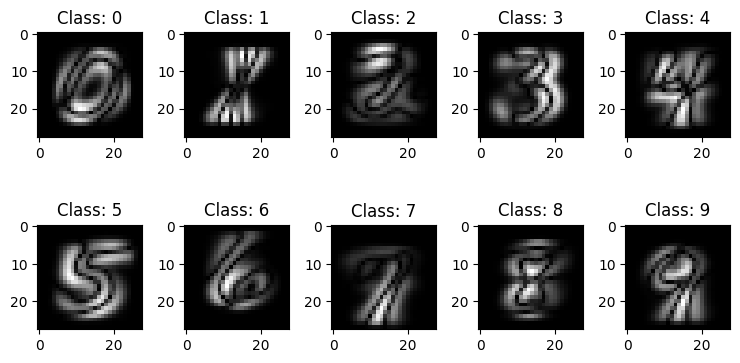

In [31]:
num_row = 2
num_col = 5
num = 10
dim = 28
length = dim * dim

# plot images
fig, axes = plt.subplots(num_row, num_col, figsize=(1.5*num_col,2*num_row))
for i in range(num):
    ax = axes[i//num_col, i%num_col]
    img = directions[0,i*length:(i+1)*length]
    img = img.reshape((dim, dim))
    ax.imshow(img, cmap='gray')
    ax.set_title('Class: {}'.format(i))
plt.tight_layout()
plt.show()

In [32]:
rs = np.random.RandomState(42)
np.random.set_state(rs.get_state())
rng = np.random.default_rng()
param = rng.standard_normal(size=[num_classes * img_size], dtype='float64')

dir_shape = [num_directions, num_classes * img_size]
directions_noise = rng.standard_normal(size=dir_shape, dtype='float64') #+ np.ones(shape=dir_shape, dtype='float64')
directions = directions_noise # + directions
projection = np.concatenate([directions, np.expand_dims(param, 0)], axis=0)
# Because the feature vector is mostly sparse, we reshape our projection matrix
reshaped = projection.transpose().reshape([num_classes, img_size, -1])


sample_indices = [i for i in range(sample_size)] #np.random.choice(num_images, size=sample_size, replace=False)
samples = []
for index in sample_indices:
    samples.append((labels[index], images[index]))
    #if len(samples) == num_classes:
    #    break

sampled_labels, sampled_images = (np.array(ary) for ary in zip(*samples))
#projected = training_set[sample_indices, :] @ reshaped
projected = sampled_images @ reshaped

In [33]:
num_row = 2
num_col = 5
num = 10
dim = 28
length = dim * dim

sampled = sampled_images[0]
print(sampled.shape)
squeezed = reshaped.squeeze()
print(squeezed.shape)
projected_img = squeezed * sampled
print(projected_img.shape)

# plot images
fig, axes = plt.subplots(num_row, num_col, figsize=(1.5*num_col,2*num_row))
for i in range(num):
    ax = axes[i//num_col, i%num_col]
    #img = projection[0, i*length:(i+1)*length].reshape((-1))
    #img = sampled_images[0]
    img = projected_img[i,:]
    #img = projection[0, i*length:(i+1)*length].reshape((-1))
    img = img.reshape((dim, dim))
    ax.imshow(img, cmap='gray')
    ax.set_title('Class: {}'.format(i))
plt.tight_layout()
plt.show()

(784,)
(10, 784, 5)


ValueError: operands could not be broadcast together with shapes (10,784,5) (784,) 

In [18]:
for i in range(10):
    print(projected[:,i,:].reshape(-1).argmax(), sampled_labels[i])

8 5
8 0
15 4
13 1
8 9
8 2
19 1
15 3
12 1
11 4


In [34]:
polytopes = projected.transpose([1,0,2]).reshape([-1])
polytope_dim = num_classes * proj_dim
vertex_index = np.tile(np.arange(stop=polytope_dim, dtype="i"), len(samples)) // proj_dim
polytope_index = np.arange(stop=polytope_dim * len(samples), dtype="i") // polytope_dim
dim = np.tile(np.arange(stop=proj_dim, dtype="i"), len(samples) * num_classes)

with open("./labels.json", "w") as label_file:
    json.dump(sampled_labels.tolist(), label_file)

polytope_table = pa.table({"polytope": polytope_index, "vertex": vertex_index, "dim": dim, "value": polytopes})
pq.write_table(polytope_table, "mnist.parquet")
# inputs = [{"vertices" : points.tolist()} for points in polytopes]
# print(inputs[0])
# with open("mnist.json", "wt") as out_file:
#     json.dump(inputs, out_file, indent=2)

In [82]:
with open("states_out_iter2.jsonl", "rt") as states_file:
    states = [json.loads(line) for line in states_file]

In [83]:
states.sort(key=lambda x: x["accuracy"], reverse=True)
print(states[0]["minkowski_decomp"], states[0]["accuracy"])

proj_param = np.array(states[0]["param"]["data"])

proj_param = proj_param / proj_param[-1]

new_params = proj_param.reshape((-1, 1)) * projection
new_params = new_params.sum(axis=0)
 

[1, 7, 1, 8, 2, 1, 7, 8, 7, 2, 2, 7, 8, 1, 1, 7, 2, 8, 2, 7] 0.3


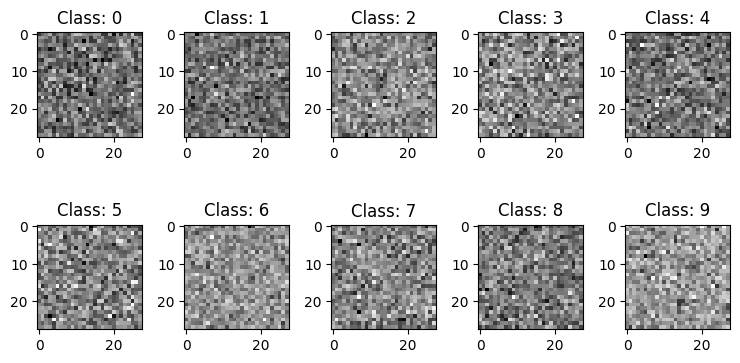

In [84]:
num_row = 2
num_col = 5
num = 10
dim = 28
length = dim * dim

# plot images
fig, axes = plt.subplots(num_row, num_col, figsize=(1.5*num_col,2*num_row))
for i in range(num):
    ax = axes[i//num_col, i%num_col]
    img = new_params[i*length:(i+1)*length]
    img = img.reshape((dim, dim))
    ax.imshow(img, cmap='gray')
    ax.set_title('Class: {}'.format(i))
plt.tight_layout()
plt.show()

In [88]:
reshaped_new_params = new_params.reshape((num_classes, -1))
print(reshaped_new_params.shape, training_set.shape)
poly_scores = training_set @ reshaped_new_params.transpose()
maximised = poly_scores.argmax(axis=1)
np.equal(maximised,training_labels).sum() / len(maximised)

(10, 784) (60000, 784)


0.12573333333333334

In [87]:
reshaped_param = param.reshape((num_classes, -1))
print(reshaped_param.shape, training_set.shape)
poly_scores = training_set @ reshaped_param.transpose()
maximised = poly_scores.argmax(axis=1)
np.equal(maximised,training_labels).sum() / len(maximised)

(10, 784) (60000, 784)


0.08648333333333333

In [89]:
sample_size_2 = num_images // 300
np.random.set_state(rs.get_state())
rng = np.random.default_rng()
#param = rng.standard_normal(size=[num_classes * img_size], dtype='float64')

dir_shape = [num_directions, num_classes * img_size]
directions_noise = rng.standard_normal(size=dir_shape, dtype='float64') #+ np.ones(shape=dir_shape, dtype='float64')
directions = directions_noise # + directions
projection = np.concatenate([directions, np.expand_dims(new_params, 0)], axis=0)
# Because the feature vector is mostly sparse, we reshape our projection matrix
reshaped = projection.transpose().reshape([num_classes, img_size, -1])


sample_indices = np.random.choice(num_images, size=sample_size_2, replace=False)
samples = []
for index in sample_indices:
    samples.append((labels[index], images[index]))
    #if len(samples) == num_classes:
    #    break

sampled_labels, sampled_images = (np.array(ary) for ary in zip(*samples))
#projected = training_set[sample_indices, :] @ reshaped
projected = sampled_images @ reshaped

In [90]:
polytopes = projected.transpose([1,0,2]).reshape([-1])
polytope_dim = num_classes * proj_dim
vertex_index = np.tile(np.arange(stop=polytope_dim, dtype="i"), len(samples)) // proj_dim
polytope_index = np.arange(stop=polytope_dim * len(samples), dtype="i") // polytope_dim
dim = np.tile(np.arange(stop=proj_dim, dtype="i"), len(samples) * num_classes)

with open("./labels.json", "w") as label_file:
    json.dump(sampled_labels.tolist(), label_file)

polytope_table = pa.table({"polytope": polytope_index, "vertex": vertex_index, "dim": dim, "value": polytopes})
pq.write_table(polytope_table, "mnist_iter2.parquet")
# inputs = [{"vertices" : points.tolist()} for points in polytopes]
# print(inputs[0])
# with open("mnist.json", "wt") as out_file:
#     json.dump(inputs, out_file, indent=2)